# Physical Signal-Chain Reconstruction Workflow

This notebook demonstrates the complete physically realistic signal-chain reconstruction and variance modeling workflow for NIR spectra.

## Workflow Overview

1. **Load and analyze real datasets** - Detect signal type, preprocessing, domain
2. **Global calibration** - Fit instrument parameters from prototypes
3. **Per-sample inversion** - Fit physical parameters via variable projection
4. **Learn parameter distributions** - Model variance in parameter space
5. **Generate synthetic data** - Sample parameters and run forward model
6. **Validate** - Compare synthetic vs real (PCA, statistics, discriminator)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# nirs4all imports
from nirs4all.data import DatasetConfigs
from nirs4all.data.synthetic.reconstruction import (
    DatasetConfig,
    ReconstructionPipeline,
    reconstruct_and_generate,
    EnvironmentalEffectsModel,
)
from nirs4all.data.signal_type import detect_signal_type

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Dataset Configuration

In [3]:
# Dataset configuration
DATASET_BASE = Path("/home/delete/NIRS DB/x_bank")

DATASET_NAMES = [
    "Beer_OriginalExtract_60_KS",
    "Biscuit_Fat_40_RandomSplit",
    "DIESEL_bp50_246_b-a",
    "grapevine_chloride_556_KS",
    "LUCAS_SOC_Organic_1102_NocitaKS",
    "Milk_Fat_1224_KS",
    "Poultry_manure_CaO_KS",
    "Rice_Amylose_313_YbasedSplit",
    "TABLET_Escitalopramt_310_Zhao",
]

# Domain mapping for component selection
DATASET_DOMAINS = {
    'Beer_OriginalExtract_60_KS': 'beverage_wine',
    'Biscuit_Fat_40_RandomSplit': 'food_bakery',
    'DIESEL_bp50_246_b-a': 'petrochem_fuels',
    'grapevine_chloride_556_KS': 'agriculture_fruit',
    'LUCAS_SOC_Organic_1102_NocitaKS': 'environmental_soil',
    'Milk_Fat_1224_KS': 'food_dairy',
    'Poultry_manure_CaO_KS': 'environmental_soil',
    'Rice_Amylose_313_YbasedSplit': 'agriculture_grain',
    'TABLET_Escitalopramt_310_Zhao': 'pharma_tablets',
}

In [4]:
def load_dataset(name: str) -> dict:
    """Load dataset with full signal analysis."""
    csv_path = DATASET_BASE / f"{name}.csv"
    config = {"x_train": str(csv_path), "delimiter": ",", "has_header": True, "header_unit": "nm"}
    ds = DatasetConfigs(config).get_datasets()[0]
    X = ds.x({}, layout='2d')
    wl = ds.wavelengths_nm(0)
    if wl is None:
        wl = np.arange(X.shape[1])

    signal_type, confidence, reason = detect_signal_type(X, wl, "nm")

    min_val, max_val = X.min(), X.max()
    mean_val = X.mean()

    # Detect preprocessing type
    is_derivative = min_val < -0.5 or (min_val < 0 and abs(mean_val) < 0.1)

    if is_derivative:
        preprocessing_type = "first_derivative"
    elif max_val > 10:
        preprocessing_type = "raw_reflectance"
    elif max_val > 3.0:
        preprocessing_type = "high_absorbance"
    else:
        preprocessing_type = "none"

    domain = DATASET_DOMAINS.get(name, 'unknown')

    return {
        'name': name,
        'X': X,
        'wl': wl,
        'n_samples': X.shape[0],
        'n_wavelengths': X.shape[1],
        'median': np.median(X, axis=0),
        'signal_type': signal_type,
        'is_derivative': is_derivative,
        'preprocessing_type': preprocessing_type,
        'domain': domain,
    }

In [5]:
# Load all datasets
datasets = []
print("=" * 100)
print(f"{'Name':<40} {'Shape':>12} {'Range':>18} {'Type':>18}")
print("-" * 100)

for name in DATASET_NAMES:
    try:
        d = load_dataset(name)
        datasets.append(d)
        print(f"{d['name'][:40]:<40} {str(d['X'].shape):>12} [{d['X'].min():.2f}, {d['X'].max():.2f}] {d['preprocessing_type']:>18}")
    except Exception as e:
        print(f"{name[:40]:<40} FAILED: {e}")

print("=" * 100)
print(f"Loaded {len(datasets)} datasets")

Name                                            Shape              Range               Type
----------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS                  (60, 576) [0.23, 3.94]    high_absorbance
Biscuit_Fat_40_RandomSplit                  (72, 700) [0.24, 2.51]               none
DIESEL_bp50_246_b-a                        (226, 401) [-0.04, 0.06]   first_derivative
grapevine_chloride_556_KS                 (555, 1023) [-1.39, 68.20]   first_derivative
LUCAS_SOC_Organic_1102_NocitaKS          (1102, 4200) [0.23, 1.52]               none
Milk_Fat_1224_KS                           (402, 256) [0.00, 7.99]    high_absorbance
Poultry_manure_CaO_KS                     (144, 1003) [0.18, 1.52]               none
Rice_Amylose_313_YbasedSplit              (313, 1154) [0.07, 1.89]               none
TABLET_Escitalopramt_310_Zhao              (310, 404) [-0.65, 2.90]   first_derivative
Loaded 9 datasets


## 2. Single Dataset Reconstruction Demo

Let's demonstrate the full workflow on one dataset.

In [6]:
# Select a dataset (preferably non-derivative for clearer demonstration)
# Find first non-derivative dataset
demo_dataset = None
for d in datasets:
    if not d['is_derivative']:
        demo_dataset = d
        break

if demo_dataset is None:
    demo_dataset = datasets[0]  # Fallback to first

print(f"Demo dataset: {demo_dataset['name']}")
print(f"Shape: {demo_dataset['X'].shape}")
print(f"Signal type: {demo_dataset['signal_type']}")
print(f"Preprocessing: {demo_dataset['preprocessing_type']}")
print(f"Domain: {demo_dataset['domain']}")

Demo dataset: Beer_OriginalExtract_60_KS
Shape: (60, 576)
Signal type: SignalType.UNKNOWN
Preprocessing: high_absorbance
Domain: beverage_wine


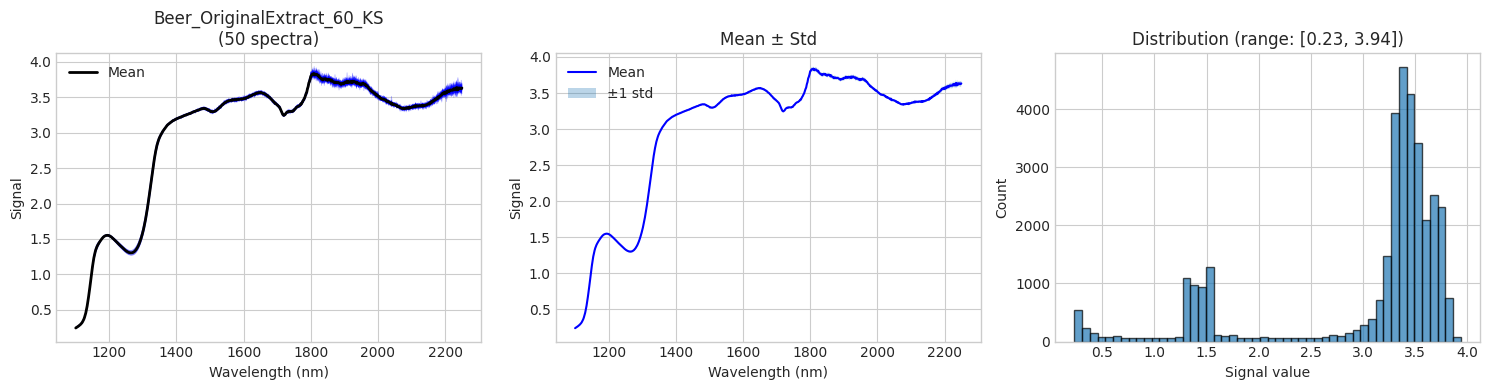

In [7]:
# Visualize the dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

X = demo_dataset['X']
wl = demo_dataset['wl']

# Plot all spectra (subset)
ax = axes[0]
n_plot = min(50, X.shape[0])
for i in range(n_plot):
    ax.plot(wl, X[i], alpha=0.3, color='blue', linewidth=0.5)
ax.plot(wl, X.mean(axis=0), 'k-', linewidth=2, label='Mean')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Signal')
ax.set_title(f'{demo_dataset["name"]}\n({n_plot} spectra)')
ax.legend()

# Plot mean ± std
ax = axes[1]
mean = X.mean(axis=0)
std = X.std(axis=0)
ax.plot(wl, mean, 'b-', label='Mean')
ax.fill_between(wl, mean - std, mean + std, alpha=0.3, label='±1 std')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Signal')
ax.set_title('Mean ± Std')
ax.legend()

# Histogram of values
ax = axes[2]
ax.hist(X.flatten(), bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Signal value')
ax.set_ylabel('Count')
ax.set_title(f'Distribution (range: [{X.min():.2f}, {X.max():.2f}])')

plt.tight_layout()
plt.show()

## 3. Run Reconstruction Pipeline

In [8]:
# Create dataset configuration
config = DatasetConfig.from_data(
    X=demo_dataset['X'],
    wavelengths=demo_dataset['wl'],
    name=demo_dataset['name'],
)
config.domain = demo_dataset['domain']

print("Detected Configuration:")
print(f"  Signal type: {config.signal_type}")
print(f"  Preprocessing: {config.preprocessing}")
print(f"  Domain: {config.domain}")

Detected Configuration:
  Signal type: unknown
  Preprocessing: none
  Domain: beverage_wine


In [ ]:
# Run the full reconstruction pipeline
pipeline = ReconstructionPipeline(
    config=config,
    n_prototypes=5,
    fit_environmental=True,  # Fit temperature, water activity, scattering
    verbose=True,
)

# Fit on the dataset (limit samples for speed in demo)
result = pipeline.fit(
    demo_dataset['X'],
    max_samples=100,  # Limit for speed
)

In [10]:
# Print summary
print(result.summary())

Reconstruction Pipeline Result: Beer_OriginalExtract_60_KS

Dataset Configuration:
  Signal type: unknown
  Preprocessing: none
  Wavelengths: 576 points
  Range: 1100 - 2250 nm

Global Calibration:
  Wavelength shift: -0.00 nm
  ILS sigma: 6.00 nm
  Total loss: 136.1481

Inversion Results:
  Samples fitted: 60
  Mean R²: 0.9432
  Min R²: 0.9424

Validation:
  Overall score: 75.0/100
  Status: PASSED


## 4. Analyze Reconstruction Quality

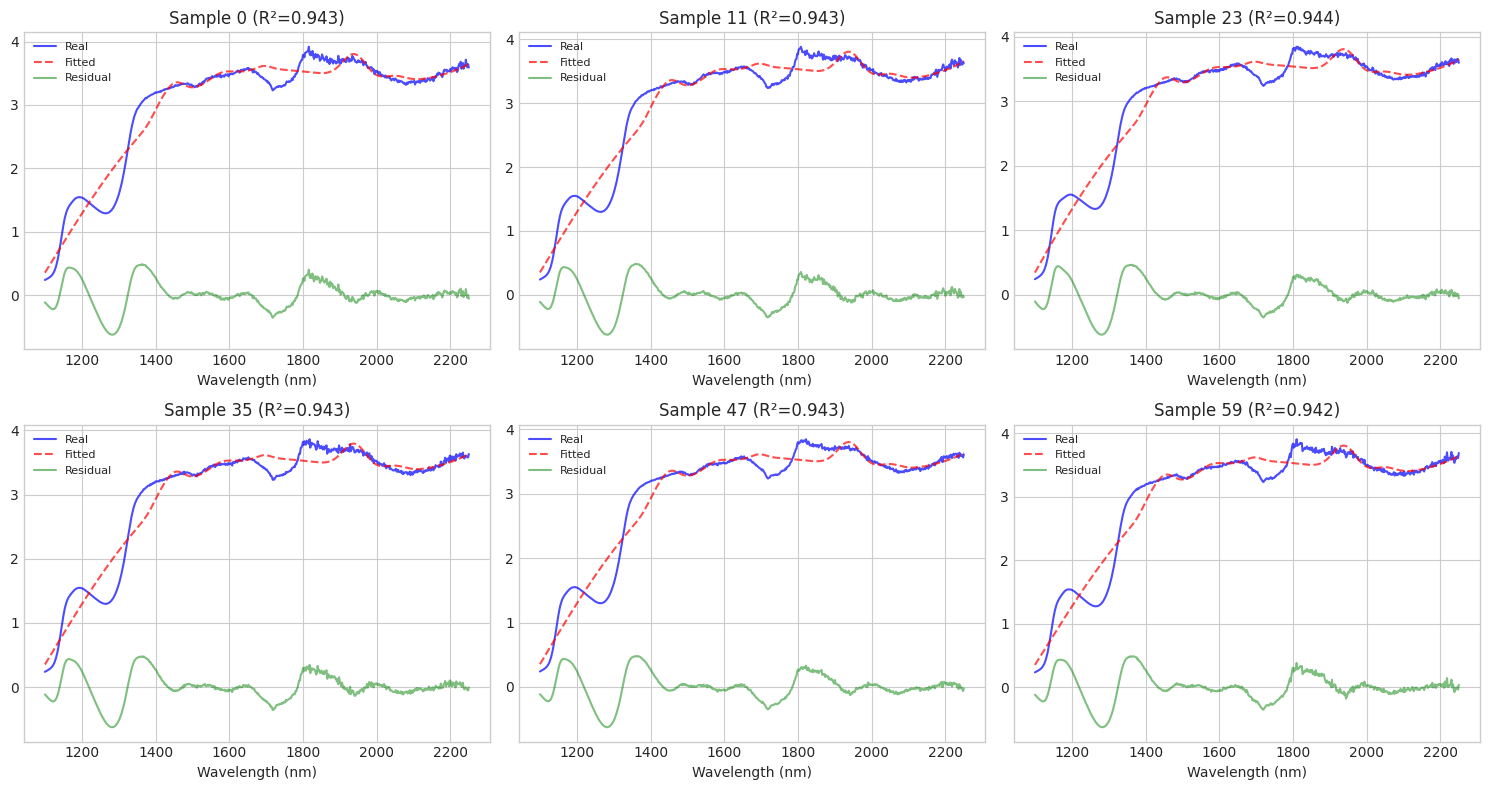

In [11]:
# Plot reconstruction examples
if result.inversion_results:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # Select a few examples
    n_examples = min(6, len(result.inversion_results))
    indices = np.linspace(0, len(result.inversion_results)-1, n_examples, dtype=int)

    X_subset = demo_dataset['X'][:len(result.inversion_results)]

    for idx, ax in zip(indices, axes.flat):
        inv = result.inversion_results[idx]

        ax.plot(wl, X_subset[idx], 'b-', label='Real', alpha=0.7)
        if inv.fitted_spectrum is not None:
            ax.plot(wl, inv.fitted_spectrum, 'r--', label='Fitted', alpha=0.7)
        if inv.residuals is not None:
            ax.plot(wl, inv.residuals, 'g-', label='Residual', alpha=0.5)

        ax.set_title(f'Sample {idx} (R²={inv.r_squared:.3f})')
        ax.legend(fontsize=8)
        ax.set_xlabel('Wavelength (nm)')

    plt.tight_layout()
    plt.show()

In [ ]:
# R² and parameter distributions
if result.inversion_results:
    r2_values = [r.r_squared for r in result.inversion_results]
    path_lengths = [r.path_length for r in result.inversion_results]
    temp_deltas = [r.temperature_delta for r in result.inversion_results if r.temperature_delta is not None]
    scatter_amps = [r.scattering_amplitude for r in result.inversion_results if r.scattering_amplitude is not None]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    ax = axes[0, 0]
    ax.hist(r2_values, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(r2_values), color='r', linestyle='--', label=f'Mean: {np.mean(r2_values):.3f}')
    ax.axvline(np.min(r2_values), color='orange', linestyle=':', label=f'Min: {np.min(r2_values):.3f}')
    ax.set_xlabel('R²')
    ax.set_ylabel('Count')
    ax.set_title('R² Distribution')
    ax.legend()

    ax = axes[0, 1]
    ax.hist(path_lengths, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(path_lengths), color='r', linestyle='--', label=f'Mean: {np.mean(path_lengths):.3f}')
    ax.set_xlabel('Path Length')
    ax.set_ylabel('Count')
    ax.set_title('Path Length Distribution')
    ax.legend()

    if temp_deltas:
        ax = axes[1, 0]
        ax.hist(temp_deltas, bins=20, edgecolor='black', alpha=0.7, color='coral')
        ax.axvline(np.mean(temp_deltas), color='r', linestyle='--', label=f'Mean: {np.mean(temp_deltas):.2f}°C')
        ax.set_xlabel('Temperature Delta (°C)')
        ax.set_ylabel('Count')
        ax.set_title('Temperature Variation')
        ax.legend()

    if scatter_amps:
        ax = axes[1, 1]
        ax.hist(scatter_amps, bins=20, edgecolor='black', alpha=0.7, color='forestgreen')
        ax.axvline(np.mean(scatter_amps), color='r', linestyle='--', label=f'Mean: {np.mean(scatter_amps):.4f}')
        ax.set_xlabel('Scattering Amplitude')
        ax.set_ylabel('Count')
        ax.set_title('Scattering Baseline')
        ax.legend()

    plt.tight_layout()
    plt.show()

## 5. Compare Synthetic vs Real

In [13]:
# Get real and synthetic data
X_real = demo_dataset['X'][:len(result.inversion_results)]
X_synth = result.X_synthetic

print(f"Real shape: {X_real.shape}")
print(f"Synthetic shape: {X_synth.shape}")

Real shape: (60, 576)
Synthetic shape: (60, 576)


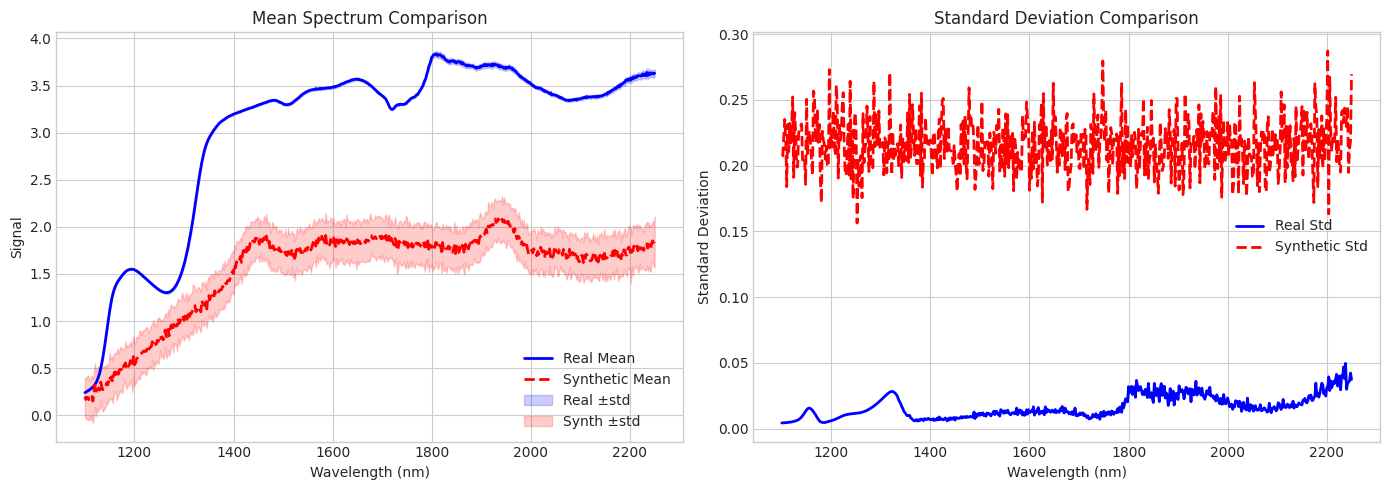

In [14]:
# Compare mean and std spectra
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean comparison
ax = axes[0]
ax.plot(wl, X_real.mean(axis=0), 'b-', label='Real Mean', linewidth=2)
ax.plot(wl, X_synth.mean(axis=0), 'r--', label='Synthetic Mean', linewidth=2)
ax.fill_between(wl,
                X_real.mean(axis=0) - X_real.std(axis=0),
                X_real.mean(axis=0) + X_real.std(axis=0),
                alpha=0.2, color='blue', label='Real ±std')
ax.fill_between(wl,
                X_synth.mean(axis=0) - X_synth.std(axis=0),
                X_synth.mean(axis=0) + X_synth.std(axis=0),
                alpha=0.2, color='red', label='Synth ±std')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Signal')
ax.set_title('Mean Spectrum Comparison')
ax.legend()

# Std comparison
ax = axes[1]
ax.plot(wl, X_real.std(axis=0), 'b-', label='Real Std', linewidth=2)
ax.plot(wl, X_synth.std(axis=0), 'r--', label='Synthetic Std', linewidth=2)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation Comparison')
ax.legend()

plt.tight_layout()
plt.show()

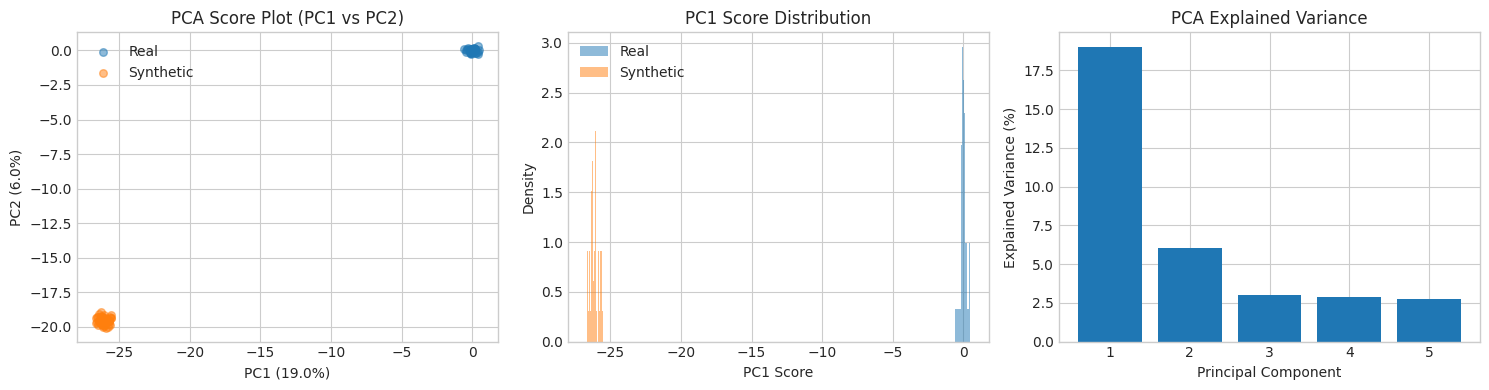

In [15]:
# PCA comparison
from sklearn.decomposition import PCA

n_comp = min(5, X_real.shape[0] - 1, X_synth.shape[0] - 1)
pca = PCA(n_components=n_comp)

# Fit on real, transform both
scores_real = pca.fit_transform(X_real)
scores_synth = pca.transform(X_synth)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# PC1 vs PC2
ax = axes[0]
ax.scatter(scores_real[:, 0], scores_real[:, 1], alpha=0.5, label='Real', s=30)
ax.scatter(scores_synth[:, 0], scores_synth[:, 1], alpha=0.5, label='Synthetic', s=30)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA Score Plot (PC1 vs PC2)')
ax.legend()

# PC1 histogram
ax = axes[1]
ax.hist(scores_real[:, 0], bins=20, alpha=0.5, label='Real', density=True)
ax.hist(scores_synth[:, 0], bins=20, alpha=0.5, label='Synthetic', density=True)
ax.set_xlabel('PC1 Score')
ax.set_ylabel('Density')
ax.set_title('PC1 Score Distribution')
ax.legend()

# Explained variance
ax = axes[2]
ax.bar(range(1, n_comp + 1), pca.explained_variance_ratio_ * 100)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance (%)')
ax.set_title('PCA Explained Variance')

plt.tight_layout()
plt.show()

## 6. Validation Metrics

In [16]:
# Print validation results
if result.validation:
    print(result.validation.summary())

Reconstruction Validation Summary
Overall Score: 75.0/100
Status: PASSED

Reconstruction Quality:
  mean_r2: 0.9432
  min_r2: 0.9424
  r2_above_threshold: 1.0000
  mean_rmse: 0.2178
  median_rmse: 0.2180
  mean_residual_magnitude: 0.1498
  residual_autocorr: 0.9916
  high_freq_residual_energy: 0.0031

Synthetic vs Real Comparison:
  mean_spectrum_correlation: 0.9638
  std_spectrum_correlation: 0.0220
  relative_mean_difference: 0.4869
  relative_std_difference: 16.2691
  pca_score_1_ks_stat: 1.0000
  pca_score_1_ks_pvalue: 0.0000
  pca_score_2_ks_stat: 1.0000
  pca_score_2_ks_pvalue: 0.0000
  pca_score_3_ks_stat: 1.0000
  pca_score_3_ks_pvalue: 0.0000
  pca_variance_real: [0.1899958699941635, 0.060164716094732285, 0.029789285734295845]
  discriminator_accuracy: 1.0000


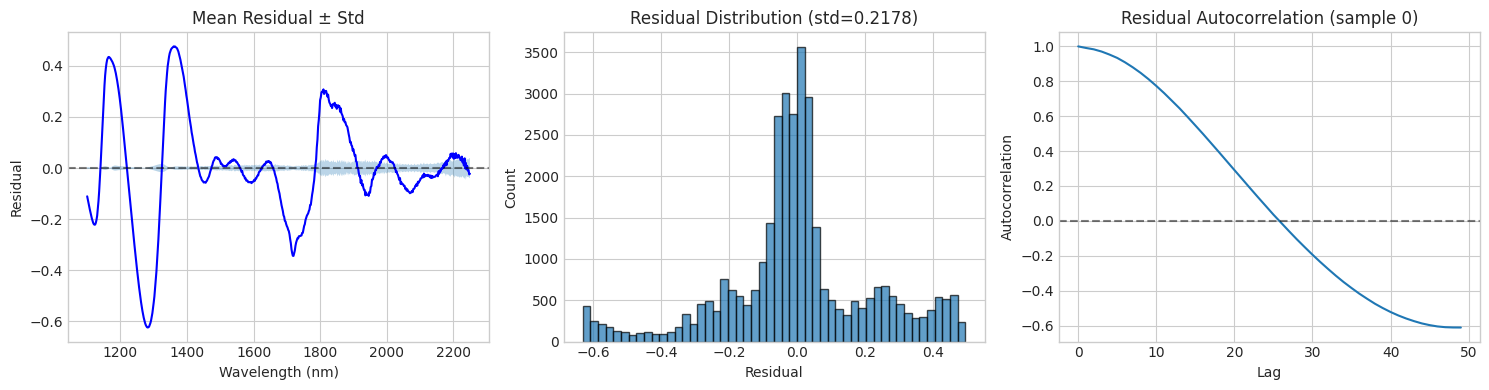

In [17]:
# Residual analysis
if result.inversion_results:
    residuals = np.array([
        r.residuals for r in result.inversion_results
        if r.residuals is not None
    ])

    if len(residuals) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Mean residual
        ax = axes[0]
        mean_res = residuals.mean(axis=0)
        ax.plot(wl, mean_res, 'b-')
        ax.fill_between(wl, -residuals.std(axis=0), residuals.std(axis=0), alpha=0.3)
        ax.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Residual')
        ax.set_title('Mean Residual ± Std')

        # Residual histogram
        ax = axes[1]
        ax.hist(residuals.flatten(), bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Residual')
        ax.set_ylabel('Count')
        ax.set_title(f'Residual Distribution (std={residuals.std():.4f})')

        # Autocorrelation of residuals
        ax = axes[2]
        from scipy.signal import correlate
        sample_res = residuals[0]
        autocorr = correlate(sample_res, sample_res, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        ax.plot(autocorr[:50])
        ax.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        ax.set_title('Residual Autocorrelation (sample 0)')

        plt.tight_layout()
        plt.show()

## 7. Generate Additional Synthetic Data

In [18]:
# Generate more synthetic samples
X_synth_new = pipeline.generate(
    n_samples=500,
    result=result,
    random_state=123,
)

print(f"Generated {X_synth_new.shape[0]} new synthetic samples")

Generated 500 new synthetic samples


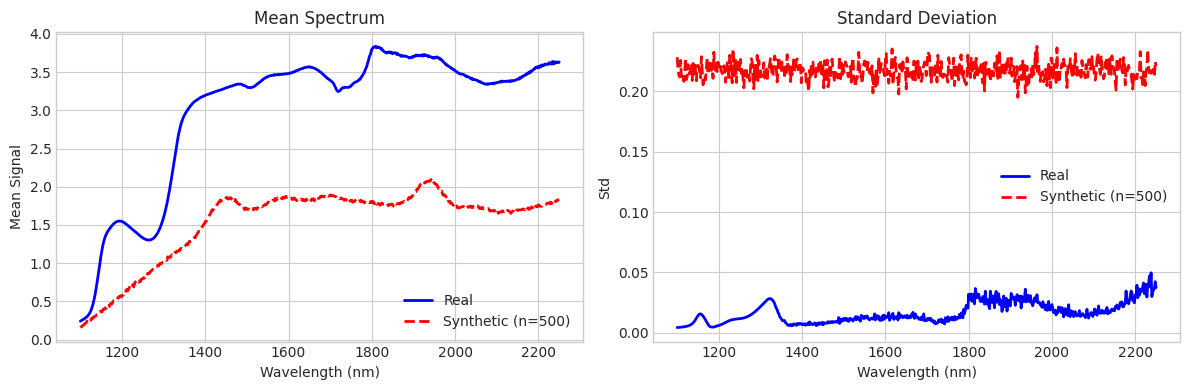

In [19]:
# Compare statistics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(wl, X_real.mean(axis=0), 'b-', label='Real', linewidth=2)
ax.plot(wl, X_synth_new.mean(axis=0), 'r--', label='Synthetic (n=500)', linewidth=2)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Mean Signal')
ax.set_title('Mean Spectrum')
ax.legend()

ax = axes[1]
ax.plot(wl, X_real.std(axis=0), 'b-', label='Real', linewidth=2)
ax.plot(wl, X_synth_new.std(axis=0), 'r--', label='Synthetic (n=500)', linewidth=2)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Std')
ax.set_title('Standard Deviation')
ax.legend()

plt.tight_layout()
plt.show()

## 8. Multi-Dataset Evaluation

In [ ]:
# Run reconstruction on multiple datasets
results_all = {}

for d in datasets[:3]:  # Process first 3 for demo
    print(f"\n{'='*60}")
    print(f"Processing: {d['name']}")
    print(f"{'='*60}")

    try:
        # Use convenience function with environmental fitting
        X_synth, pipe_result = reconstruct_and_generate(
            X=d['X'],
            wavelengths=d['wl'],
            domain=d['domain'],
            fit_environmental=True,
            verbose=True,
        )

        results_all[d['name']] = {
            'result': pipe_result,
            'X_synth': X_synth,
            'X_real': d['X'],
        }

        if pipe_result.validation:
            print(f"\nValidation Score: {pipe_result.validation.overall_score:.1f}/100")

    except Exception as e:
        print(f"Failed: {e}")

In [ ]:
# Summary table
print("\n" + "=" * 80)
print(f"{'Dataset':<35} {'Mean R²':>10} {'Score':>10} {'Status':>15}")
print("-" * 80)

for name, data in results_all.items():
    r = data['result']
    if r.inversion_results:
        mean_r2 = np.mean([inv.r_squared for inv in r.inversion_results])
    else:
        mean_r2 = 0

    score = r.validation.overall_score if r.validation else 0
    status = 'PASSED' if (r.validation and r.validation.passed) else 'NEEDS REVIEW'

    print(f"{name[:35]:<35} {mean_r2:>10.4f} {score:>10.1f} {status:>15}")

print("=" * 80)

## 9. Conclusion

This notebook demonstrated the physical signal-chain reconstruction workflow:

1. **Datasets were loaded** with automatic detection of signal type and preprocessing
2. **Global instrument parameters** were calibrated using prototype spectra
3. **Per-sample physical parameters** were fitted using variable projection, including:
   - Component concentrations and path length
   - Temperature variations (region-specific shifts)
   - Water activity (free vs bound water)
   - Scattering baseline (λ^-n wavelength dependence)
4. **Parameter distributions** were learned to model spectral variance
5. **Synthetic data** was generated by sampling from learned distributions
6. **Validation** compared synthetic vs real data statistics

### Key Metrics

- **Reconstruction R²**: How well the forward model fits individual spectra
- **Mean spectrum correlation**: How well synthetic matches real mean
- **Discriminator accuracy**: How distinguishable synthetic is from real (lower = better)
- **PCA score distributions**: Whether synthetic captures the same variance structure